# CelebA — Eyeglasses: Subset + Preprocessing (Classroom Workflow)

This notebook guides you through a clear workflow to prepare a balanced Eyeglasses subset of CelebA and preprocess images for training:

1) Review archive and attribute balance
2) Build a balanced subset (eyeglasses vs no_eyeglasses)
3) Preprocess: center-crop/resize and compute TRAIN channel stats
4) Analyze processed dataset

Notes:
- Prerequisites: download CelebA under `data/celeba/archive/` as described in `README.md`.
- The notebook uses `src/*` helpers; no code duplication.
- Runs top-to-bottom on a fresh kernel.


In [1]:
# Setup
import os, sys, logging, random
from pathlib import Path
import numpy as np

try:
    import matplotlib.pyplot as plt
except ImportError as e:
    raise ImportError("matplotlib is required: pip install matplotlib") from e

# Reproducibility
RANDOM_SEED = int(os.environ.get("RANDOM_SEED", "42"))
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
logger = logging.getLogger(__name__)

# Ensure repository root is on sys.path so `import src.*` works from notebooks/
PROJECT_ROOT = None
for candidate in [Path.cwd()] + list(Path.cwd().parents):
    if (candidate / "src").exists():
        PROJECT_ROOT = candidate
        if str(candidate) not in sys.path:
            sys.path.insert(0, str(candidate))
        break
if PROJECT_ROOT is None:
    raise RuntimeError("Could not locate repository root containing 'src' directory.")

plt.style.use("seaborn-v0_8-whitegrid")



In [2]:
# Imports from src
from dataclasses import dataclass
from typing import Optional, Sequence

# Ensure we see latest edits without restarting the kernel
import importlib
import src.celeba_workflow as _cw
_cw = importlib.reload(_cw)

from src.celeba_workflow import (
    Config,
    review_archive,
    build_subset,
    preprocess_images,
    analyze_original_subset,
    analyze_processed,
)



In [3]:
# Config (lean)
datadir = PROJECT_ROOT / "data/celeba"
ARCHIVE_DIR = datadir / "archive"
IMAGES_ROOT = ARCHIVE_DIR / "img_align_celeba/img_align_celeba"
OUTPUT_DIR = PROJECT_ROOT / "data/celeba/subsets/eyeglasses_balanced_20k"
OUT_ROOT = PROJECT_ROOT / "data/celeba/processed/eyeglasses_balanced_20k_64"

for p in [OUTPUT_DIR, OUT_ROOT]:
    p.mkdir(parents=True, exist_ok=True)

cfg = Config(
    archive_dir=ARCHIVE_DIR,
    images_root=IMAGES_ROOT,
    output_dir=OUTPUT_DIR,
    subset_root=OUTPUT_DIR,
    out_root=OUT_ROOT,
)



In [4]:
# Preview key config values
print("Paths:\n- archive_dir:", cfg.archive_dir,
      "\n- images_root:", cfg.images_root,
      "\n- subset_root:", cfg.subset_root,
      "\n- out_root:", cfg.out_root)
print("\nSubset caps (per class):", {"train": cfg.max_train, "val": cfg.max_val, "test": cfg.max_test})
print("Preprocess:", {"size": cfg.preprocess_size,
                     "center_crop": cfg.preprocess_center_crop,
                     "normalize_01": cfg.preprocess_normalize_01,
                     "compute_stats": cfg.preprocess_compute_stats})
print("Flags:", {"plot": cfg.plot, "dry_run": cfg.dry_run, "overwrite": cfg.overwrite})


Paths:
- archive_dir: /Users/caroline/Cursor/dp_sgd_classification/data/celeba/archive 
- images_root: /Users/caroline/Cursor/dp_sgd_classification/data/celeba/archive/img_align_celeba/img_align_celeba 
- subset_root: /Users/caroline/Cursor/dp_sgd_classification/data/celeba/subsets/eyeglasses_balanced_20k 
- out_root: /Users/caroline/Cursor/dp_sgd_classification/data/celeba/processed/eyeglasses_balanced_20k_64

Subset caps (per class): {'train': 8000, 'val': 1000, 'test': 1000}
Preprocess: {'size': 64, 'center_crop': True, 'normalize_01': True, 'compute_stats': True}
Flags: {'plot': True, 'dry_run': False, 'overwrite': True}


Review archive with: {'archive_dir': '/Users/caroline/Cursor/dp_sgd_classification/data/celeba/archive', 'plot_top_n_attrs': 20}


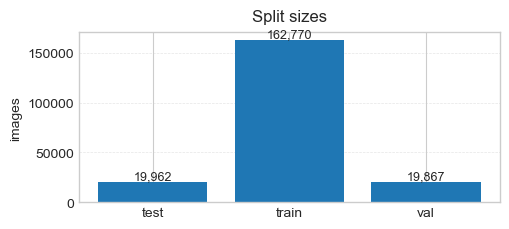

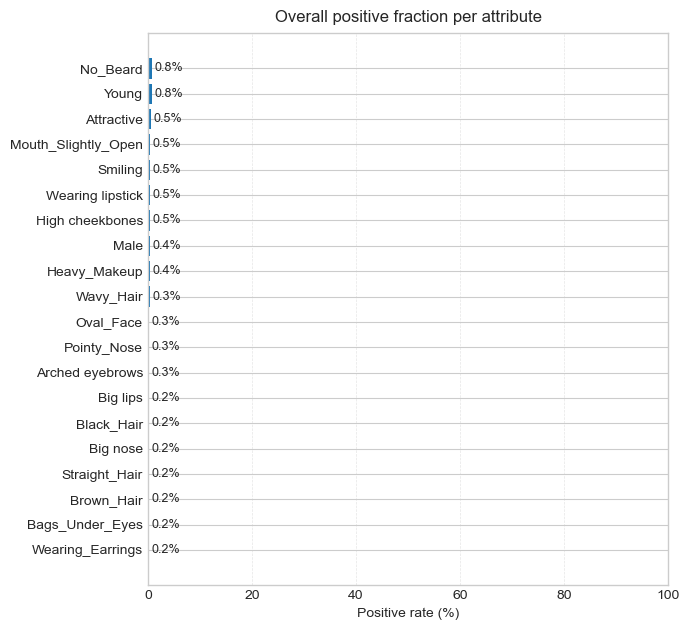

INFO: Review archive section completed.


In [5]:
# 1) Review archive
print("Review archive with:", {"archive_dir": str(cfg.archive_dir), "plot_top_n_attrs": cfg.plot_top_n_attrs})
review_archive(cfg)


In [6]:
# 2) Build subset
print("Build subset with:", {
    "attribute": cfg.attribute,
    "max_train": cfg.max_train,
    "max_val": cfg.max_val,
    "max_test": cfg.max_test,
    "link_mode": cfg.link_mode,
    "overwrite": cfg.overwrite,
    "dry_run": cfg.dry_run,
    "output_dir": str(cfg.output_dir),
})
# Capture and summarize skipped images; write skipped_missing_images.csv
from src.celeba_workflow import build_subset_with_skip_summary
build_subset_with_skip_summary(cfg, suppress_per_file_logs=True)


INFO: Running build-subset (captured): celeba_build_subset --archive-dir /Users/caroline/Cursor/dp_sgd_classification/data/celeba/archive --images-root /Users/caroline/Cursor/dp_sgd_classification/data/celeba/archive/img_align_celeba/img_align_celeba --output-dir /Users/caroline/Cursor/dp_sgd_classification/data/celeba/subsets/eyeglasses_balanced_20k --attribute Eyeglasses --max-per-class-train 8000 --max-per-class-val 1000 --max-per-class-test 1000 --link-mode copy --seed 42 --overwrite


Build subset with: {'attribute': 'Eyeglasses', 'max_train': 8000, 'max_val': 1000, 'max_test': 1000, 'link_mode': 'copy', 'overwrite': True, 'dry_run': False, 'output_dir': '/Users/caroline/Cursor/dp_sgd_classification/data/celeba/subsets/eyeglasses_balanced_20k'}
Using attribute: Eyeglasses
Images root: /Users/caroline/Cursor/dp_sgd_classification/data/celeba/archive/img_align_celeba/img_align_celeba
Output dir: /Users/caroline/Cursor/dp_sgd_classification/data/celeba/subsets/eyeglasses_balanced_20k
Link mode: copy; dry-run=False; overwrite=True
Split train: target per-class cap 8000
  Kept 8000 pos, 8000 neg (total 16000)
Split val: target per-class cap 1000
  Kept 1000 pos, 1000 neg (total 2000)
Split test: target per-class cap 1000
  Kept 1000 pos, 1000 neg (total 2000)
Wrote index CSV: /Users/caroline/Cursor/dp_sgd_classification/data/celeba/subsets/eyeglasses_balanced_20k/subset_index_eyeglasses.csv
Created files under: /Users/caroline/Cursor/dp_sgd_classification/data/celeba/sub

Analyze original with: {'subset_root': '/Users/caroline/Cursor/dp_sgd_classification/data/celeba/subsets/eyeglasses_balanced_20k', 'size_sample_max': 5000, 'channel_stats_split': 'train'}


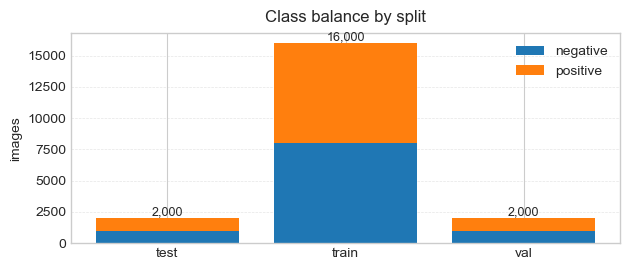

Reading image sizes: 100%|██████████| 5000/5000 [00:00<00:00, 7587.23it/s]


Accumulating channel stats: 100%|██████████| 1500/1500 [00:01<00:00, 920.75it/s]


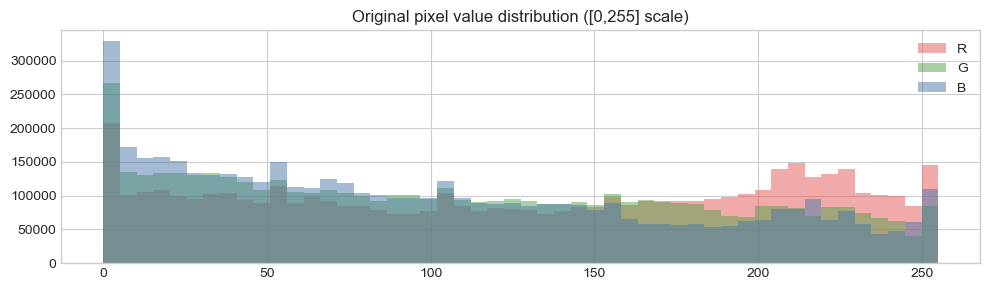

In [7]:
# 3) Analyze original subset (optional but recommended)
print("Analyze original with:", {"subset_root": str(cfg.subset_root), "size_sample_max": cfg.size_sample_max, "channel_stats_split": cfg.channel_stats_split})
analyze_original_subset(cfg)


Diagnostics preview with: {'target_size': 64, 'sample': 256}


Averaging images (original & cropped): 100%|██████████| 256/256 [00:00<00:00, 1087.75it/s]


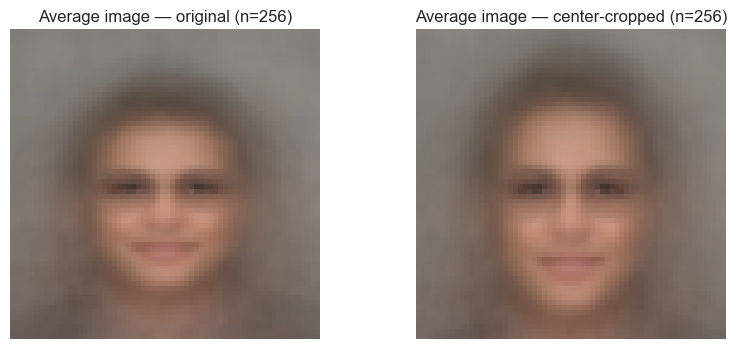

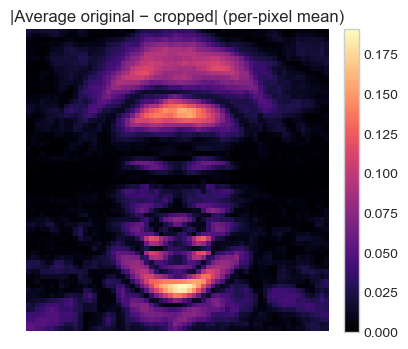

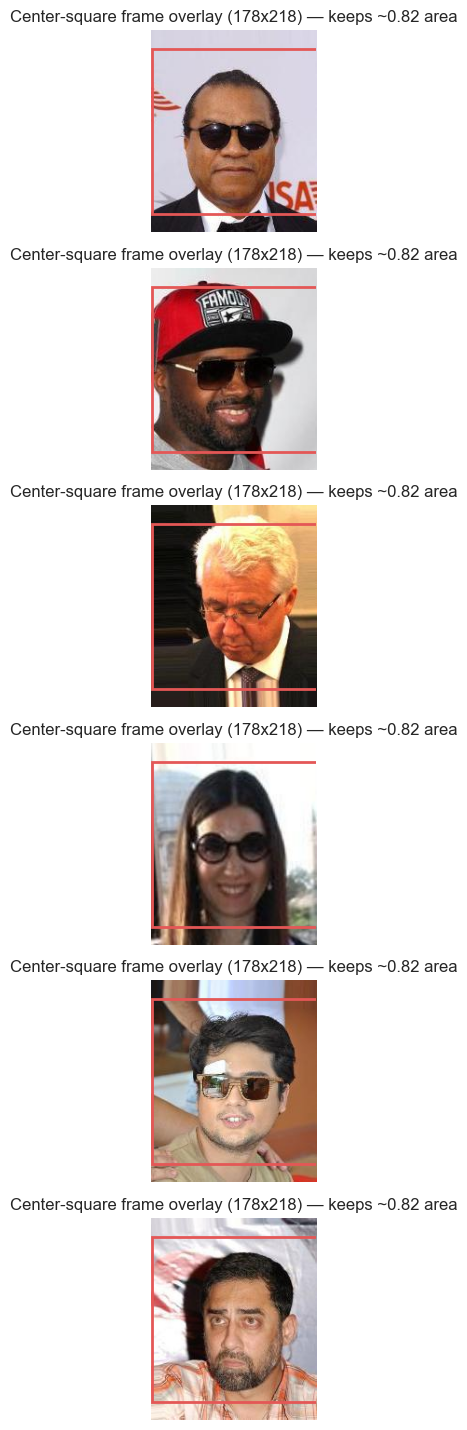

In [8]:
# 4a) Center-crop diagnostics (optional)
print("Diagnostics preview with:", {"target_size": cfg.diag_target_size, "sample": cfg.diag_visual_sample})
from src.celeba_workflow import preview_center_crop_diagnostics
preview_center_crop_diagnostics(cfg)



In [9]:
# 4b) Preprocess images
print("Preprocess with:", {
    "subset_root": str(cfg.subset_root),
    "out_root": str(cfg.out_root),
    "size": cfg.preprocess_size,
    "center_crop": cfg.preprocess_center_crop,
    "normalize_01": cfg.preprocess_normalize_01,
    "compute_stats": cfg.preprocess_compute_stats,
})
from src.celeba_workflow import preprocess_images_only
preprocess_images_only(cfg)

INFO: Running preprocess via import: celeba_preprocess --subset-root /Users/caroline/Cursor/dp_sgd_classification/data/celeba/subsets/eyeglasses_balanced_20k --out-root /Users/caroline/Cursor/dp_sgd_classification/data/celeba/processed/eyeglasses_balanced_20k_64 --size 64 --center-crop --normalize-01 --compute-stats


Preprocess with: {'subset_root': '/Users/caroline/Cursor/dp_sgd_classification/data/celeba/subsets/eyeglasses_balanced_20k', 'out_root': '/Users/caroline/Cursor/dp_sgd_classification/data/celeba/processed/eyeglasses_balanced_20k_64', 'size': 64, 'center_crop': True, 'normalize_01': True, 'compute_stats': True}


Processing images: 100%|██████████| 20000/20000 [00:14<00:00, 1383.58it/s]


Processed images written to: /Users/caroline/Cursor/dp_sgd_classification/data/celeba/processed/eyeglasses_balanced_20k_64
Total processed: 20000 (skipped: 0)
By split: {'train': 16000, 'val': 2000, 'test': 2000}
By class: {'no_eyeglasses': 10000, 'eyeglasses': 10000}


Measuring processed sizes: 100%|██████████| 20000/20000 [00:02<00:00, 9896.13it/s] 
INFO: Updated processed_index.csv with width/height columns
INFO: Summary:
INFO: - Processed root: /Users/caroline/Cursor/dp_sgd_classification/data/celeba/processed/eyeglasses_balanced_20k_64
INFO: - Total processed: 20000 | By split: {'test': 2000, 'train': 16000, 'val': 2000} | By class: {'eyeglasses': 10000, 'no_eyeglasses': 10000}


total (before) total (after) pos% (before) pos% (after) Δ pos% (pp)
split                                                                    
test           2,000         2,000         50.0%        50.0%        +0.0
train         16,000        16,000         50.0%        50.0%        +0.0
val            2,000         2,000         50.0%        50.0%        +0.0

Reading image sizes: 100%|██████████| 5000/5000 [00:00<00:00, 15160.20it/s]


Accumulating channel stats: 100%|██████████| 1500/1500 [00:00<00:00, 4974.66it/s]


mean (before)  mean (after)    Δ mean  std (before)  std (after)     Δ std
                                                                             
R       0.501287      0.505404  0.004117      0.311969     0.303956 -0.008013
G       0.426791      0.425017 -0.001774      0.293002     0.284168 -0.008834
B       0.390930      0.385766 -0.005164      0.293166     0.283823 -0.009343

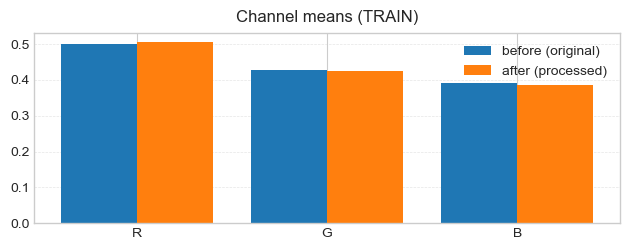

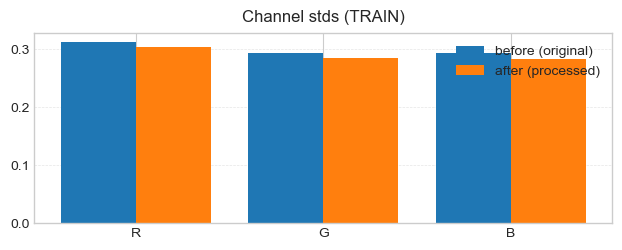

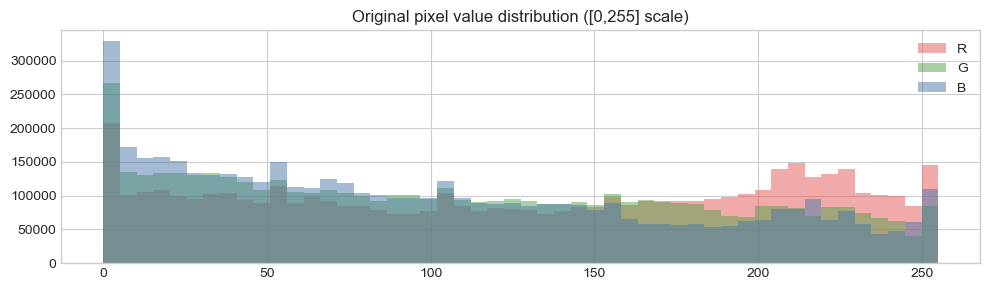

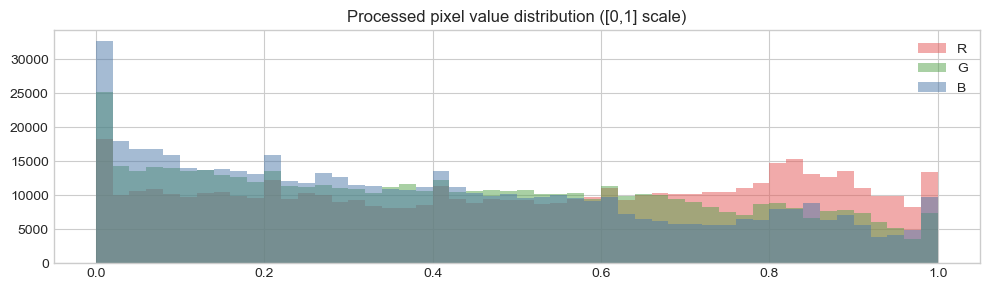

In [10]:
# 5) Analyze processed dataset
from IPython.display import display, HTML
_html = (
    "<div style='color:#374151'>Analyze processed with:</div>"
    f"<pre style='margin:4px 0 8px 0'>out_root = {cfg.out_root}\nproc_pixel_hist_bins = {cfg.proc_pixel_hist_bins}</pre>"
)
display(HTML(_html))

analyze_processed(cfg)
